# Broadband source analysis

Switching to a broadband light source would dramatically reduce the footprint of scan rigs, and likely eliminate speckle. How much signal/crosstalk can we expect with our current filters?

Use a 3 mm LLG Thorlabs plasma lamp throughout. Gain an extra 7/4 (typical) in power if switching to a 5 mm LLG model. 

Note that for safety and to minimise the chance of short wavelength light leaking through unexpectedly from spectral windows not covered by the provided spectra, we might want to put a ~395LP filter as close as possible to the output of the LLG. This hasn't been included in this modelling. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from dye import Dye
from laser import Laser
from filterCube import FilterCube
from camera import Camera
from objective import Objective
from broadbandSource import BroadbandSource
import utils
from crosstalk_analysis import signalFromDyeXInChannelY
from crosstalk_analysis import displayCrosstalkPlot

dyesPath = 'Dye spectra/'
filtersPath = 'Filter spectra/'
opticsPath =  'Optics spectra/'
cameraPath = 'Camera spectra/'
sourcesPath = 'Source spectra/'


%config InlineBackend.figure_format = 'retina'

__Sources for dye data:__

Atto general properties: https://www.atto-tec.com/fileadmin/user_upload/Katalog_Flyer_Support/Dye_Properties_01.pdf

Atto spectra: https://www.atto-tec.com/attotecshop/product_info.php?language=en&info=p117_ATTO-700.html

Alexa 405 absorption coefficient: http://www.atdbio.com/content/34/Alexa-dyes

Alexa 405 QY: http://confocal-microscopy-list.588098.n2.nabble.com/alexa-405-QY-td6913848.html

Alexa 405 spectra: https://www.chroma.com/spectra-viewer?fluorochromes=10533


__Sources for filter spectra:__

Semrock filters: http://www.laser2000.co.uk

Chroma 700 dichroics: emailed from Chroma


__Sources for camera spectra:__

Andor Zyla 5.5: https://searchlight.semrock.com/


__Sources for optics (objective) spectra:__

UPLANSAPO20x: https://www.olympus-lifescience.com/en/objectives/uplsapo/#!cms[tab]=%2Fobjectives%2Fuplsapo%2F20x, data extracted from curve using WebPlotDigitiser: http://arohatgi.info/WebPlotDigitizer/app/


Next, define (manually and in a boilerplate-y manner) the components of the system we are investigating. 

In [2]:
dye405 = Dye(name = 'Alexa405', epsilon = 35000, qy = 0.54, 
             absSpectrum = os.path.join(dyesPath, 'Alexa405abs.txt'), 
             emSpectrum = os.path.join(dyesPath, 'Alexa405em.txt'))
          
dye532 = Dye(name = 'Atto532', epsilon = 115000, qy = 0.9, 
             absSpectrum = os.path.join(dyesPath, 'ATTO532_PBS.abs.txt'), 
             emSpectrum = os.path.join(dyesPath, 'ATTO532_PBS.ems.txt'))

dye594 = Dye(name = 'Atto594', epsilon = 120000, qy = 0.85, 
             absSpectrum = os.path.join(dyesPath, 'ATTO594_PBS.abs.txt'), 
             emSpectrum = os.path.join(dyesPath, 'ATTO594_PBS.ems.txt'))

dye633 = Dye(name = "Atto655", epsilon = 125000, qy = 0.3, 
          absSpectrum = os.path.join(dyesPath, 'ATTO655_PBS.abs.txt'), 
          emSpectrum = os.path.join(dyesPath, 'ATTO655_PBS.ems.txt') )        

dye700 = Dye(name = "Atto700", epsilon = 120000, qy = 0.25, 
          absSpectrum = os.path.join(dyesPath, 'ATTO700_PBS.abs.txt'), 
          emSpectrum = os.path.join(dyesPath, 'ATTO700_PBS.ems.txt') )         
          
l405 = Laser(channel = 'L405Nm', centreWavelengthNm = 405, fwhmNm = 0.01, 
             laserOutputPowerMw = 3)
             
l532 = Laser(channel = 'L532Nm', centreWavelengthNm = 532, fwhmNm = 0.01, 
             laserOutputPowerMw = 18)
             
l594 = Laser(channel = 'L594Nm', centreWavelengthNm = 594, fwhmNm = 0.01, 
             laserOutputPowerMw = 25)             
          
l633 = Laser(channel = 'L633Nm', centreWavelengthNm = 640, fwhmNm = 0.01, 
             laserOutputPowerMw = 30)
          
l700 = Laser(channel = 'L700Nm', centreWavelengthNm = 701, fwhmNm = 0.01, 
             laserOutputPowerMw = 30)

bb = BroadbandSource(name='Thorlabs HPLS343, 3mm LLG', 
                     integratedPowermW=4000.0, 
                     spectrum=os.path.join(sourcesPath, 'Thorlabs Plasma Source.txt'))
             
fc405 = FilterCube(channel = 'L405Nm', 
                   excitationFilter = ( 'FF01-390_40', os.path.join(filtersPath, 'FF01-390_40_Spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R405', os.path.join(filtersPath, 'Di02-R405_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-452_45', os.path.join(filtersPath, 'FF01-452_45_Spectrum.txt') ) )
                   
fc532 = FilterCube(channel = 'L532Nm', 
                   excitationFilter = ( 'FF01-532_3', os.path.join(filtersPath, 'FF01-532_3_spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R532', os.path.join(filtersPath, 'Di02-R532_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-562_40', os.path.join(filtersPath, 'FF01-562_40_spectrum.txt') ) )
                   
fc594 = FilterCube(channel = 'L594Nm', 
                   excitationFilter = ( 'FF01-591_6', os.path.join(filtersPath, 'FF01-591_6_Spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R594', os.path.join(filtersPath, 'Di02-R594_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-647_57', os.path.join(filtersPath, 'FF01-647_57_Spectrum.txt') ) )
             
fc633 = FilterCube(channel = 'L633Nm', 
                   excitationFilter = ( 'FF01-640_14', os.path.join(filtersPath, 'FF01-640_14_spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R635', os.path.join(filtersPath, 'Di02-R635_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-679_41', os.path.join(filtersPath, 'FF01-679_41_Spectrum.txt') ) )
                   
fc700new = FilterCube(channel = 'L700Nm', 
                   excitationFilter = ( 'FF01-692_40', os.path.join(filtersPath, 'FF01-692_40_Spectrum.txt') ), 
                   dichroicFilter = ( '725lpxr', os.path.join(filtersPath, 'Chroma 725lpxr.txt') ), 
                   emissionFilter = ( 'FF01-747_33', os.path.join(filtersPath, 'FF01-747_33_Spectrum.txt') ) )
                   
                   
camera = Camera(name = 'Andor Zyla 5.5', 
                qeCurve = os.path.join(cameraPath, 'Camera sCMOS (Andor- Zyla 5.5).txt'))

objective = Objective(name = 'Olympus UPLANSAPO20x 0.75NA', 
                      transmissionCurve = os.path.join(opticsPath, 'Olympus UPLANSAPO20x.txt'))



## Broadband source, signal from each dye

Compare signal from each dye in it's proper detection channel between current, laser-based system and putative broadband source system. 

In [3]:
def signal_per_channel(laser_list,  source_list, fc_list, dye_list):
    ratios = []
    ch_labels = []
    for l, b, fc, dy in zip(laser_list, source_list, fc_list, dye_list):
        d, ch, sig_new = signalFromDyeXInChannelY(b, fc, dy, objective, camera)
        d, ch, sig_old = signalFromDyeXInChannelY(l, fc, dy, objective, camera)
        print(ch)
        print('broadband/laser ratio = {:0.3f}'.format((sig_new/sig_old)))

        ratios.append(sig_new/sig_old)
        ch_labels.append(ch)

    fig3 = plt.figure();
    plt.bar([1, 2, 3, 4, 5], 
            ratios, 
            tick_label=ch_labels, 
            align='center')
    plt.ylabel('Fractional signal (broadband/laser)')
    plt.title('Signal comparison')
    plt.show()
    
    return ch_labels

L405Nm
broadband/laser ratio = 41.967
L532Nm
broadband/laser ratio = 2.687
L594Nm
broadband/laser ratio = 2.322
L633Nm
broadband/laser ratio = 3.006
L700Nm
broadband/laser ratio = 3.447


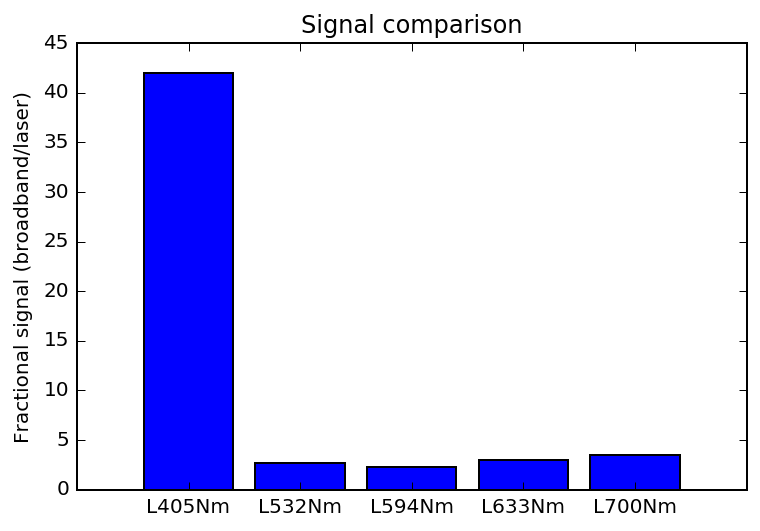

In [4]:
% matplotlib inline
laser_list = [l405, l532, l594, l633, l700]
fc_list = [fc405, fc532, fc594, fc633, fc700new]
dye_list = [dye405, dye532, dye594, dye633, dye700]
source_list = [bb, bb, bb, bb, bb]

ch_labels = signal_per_channel(laser_list,  source_list, fc_list, dye_list)


## Crosstalk

Assemble crosstalk matrices for current, laser-based setup and putative broadband setup. 

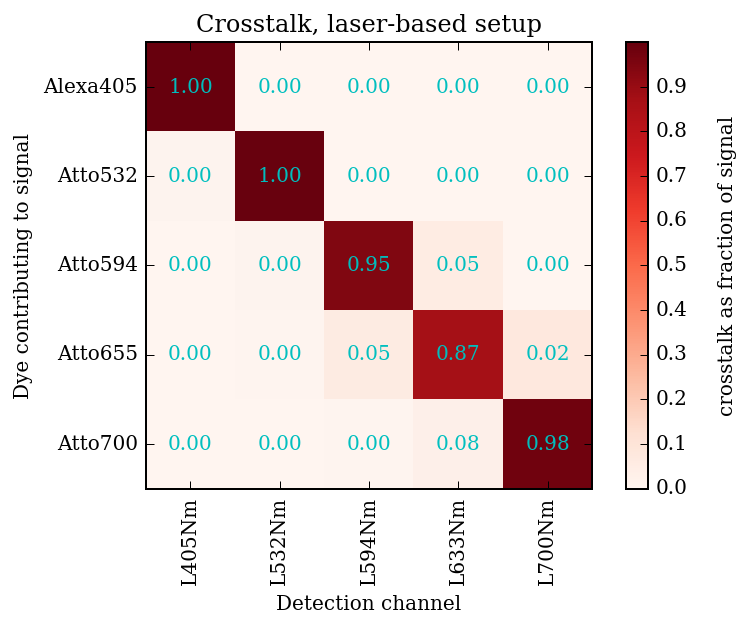

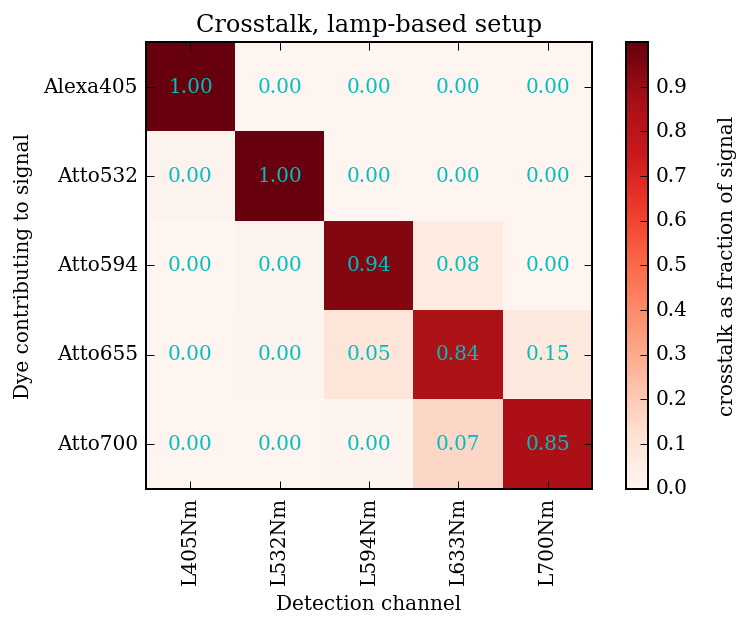

array([[  9.99999955e-01,   1.32847694e-08,   2.54718603e-08,
          3.23483497e-09,   2.54613426e-09],
       [  5.77826796e-11,   9.98715037e-01,   1.28494860e-03,
          9.41286333e-09,   5.18026960e-09],
       [  2.00284511e-17,   1.74515030e-04,   9.44686686e-01,
          5.47246275e-02,   4.14171217e-04],
       [  1.96068202e-15,   5.56160116e-08,   8.30138513e-02,
          8.44464527e-01,   7.25215657e-02],
       [  8.97044929e-11,   7.50078861e-06,   2.27537403e-04,
          1.51267516e-01,   8.48497446e-01]])

In [5]:
displayCrosstalkPlot(laser_list, 
                     fc_list, 
                     dye_list, 
                     objective, camera, log_colour=False, title='Crosstalk, laser-based setup')
#plt.title('Crosstalk, laser-based setup')
displayCrosstalkPlot(source_list, 
                     fc_list, 
                     dye_list, 
                     objective, camera, log_colour=False, title='Crosstalk, lamp-based setup')
#plt.title('Crosstalk, lamp-based setup')

## Leakage

Given that we no longer benefit from very sharp laser profile, how much excitation light will leak through the emission filters? Present the case in which the sample is a broadband mirror - from this we can infer the (much smaller) amount of scattered excitation light that might degrade our signal. 

In [6]:
def calc_leakage(source, filtercube, obj, cam):
    """Given a set of filters in a cube and a source spectrum, how excitation light is detected by the camera? """
    
    dl = 0.5
    if isinstance(source, BroadbandSource):
        s = utils.interpolateSpectrum(source.spectrum, dl)
    else:
        s = utils.interpolateSpectrum(source.laserProfile, dl)
    ex = utils.interpolateSpectrum(filtercube.excitationFilter.getSpectrum(), dl)
    di = utils.interpolateSpectrum(filtercube.dichroicFilter.getSpectrum(), dl)
    em = utils.interpolateSpectrum(filtercube.emissionFilter.getSpectrum(), dl)
    c = utils.interpolateSpectrum(camera.qeCurve, dl)
    o = utils.interpolateSpectrum(obj.transmissionCurve, dl)
    diIn = np.zeros_like(di)
    diIn[:,0] = di[:,0]
    diIn[:,1] = 1 - di[:,1]
    
    spList = [s, ex, diIn, o, o, di, em, c]
    
    leakage = utils.integrateSpectra(spList, dl)
    
    return leakage

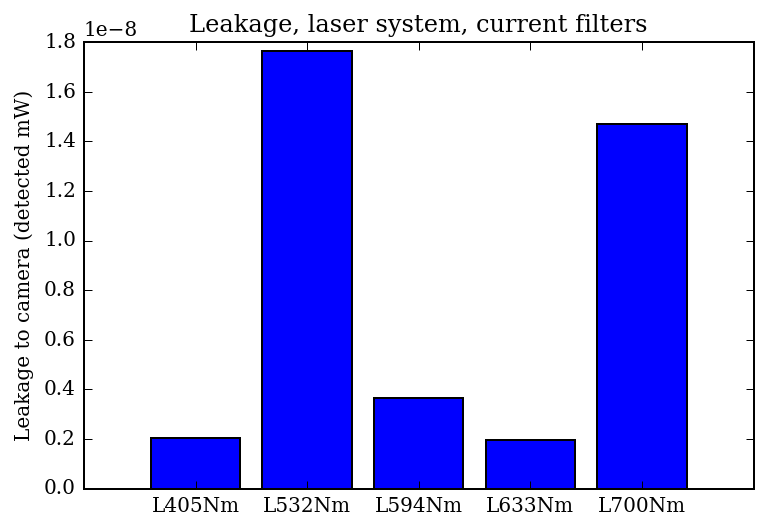

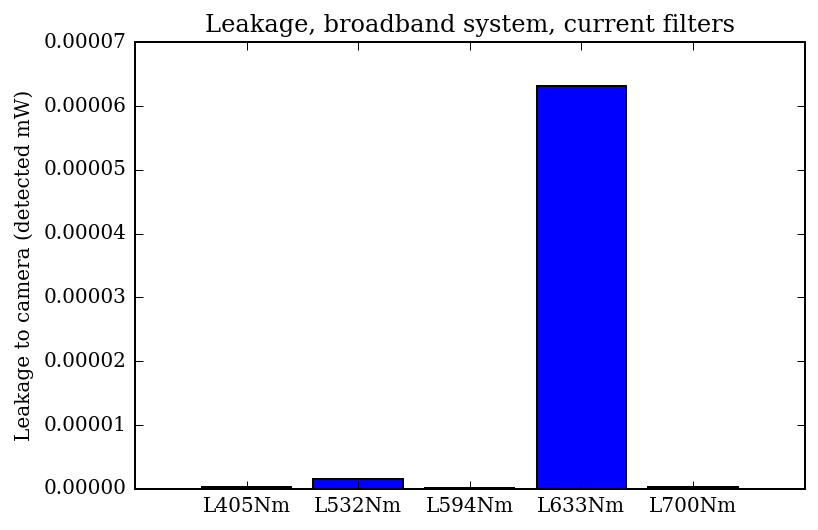

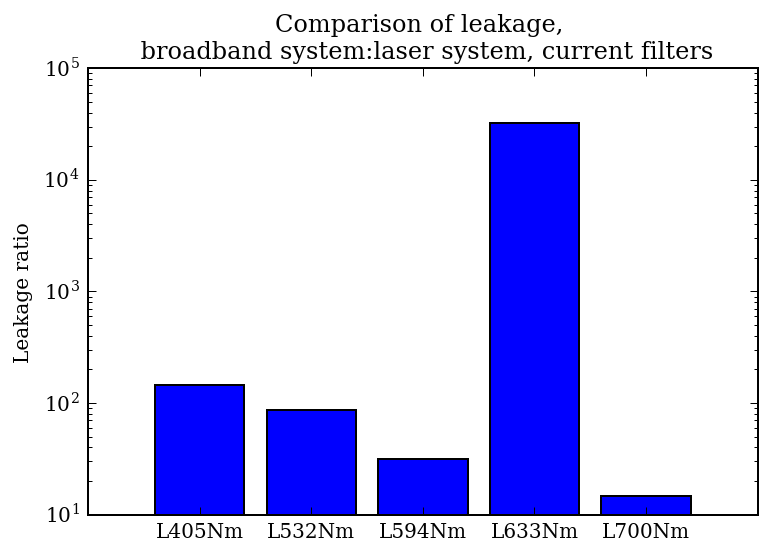

In [16]:
laser_leakage = [calc_leakage(lsr, fc, objective, camera) for lsr, fc in zip(laser_list, fc_list)]

fig4 = plt.figure();
plt.bar([1, 2, 3, 4, 5], 
        laser_leakage, 
        tick_label=ch_labels, 
        align='center')
plt.ylabel('Leakage to camera (detected mW)')
plt.title('Leakage, laser system, current filters')
plt.show()

bb_leakage = [calc_leakage(sr, fc, objective, camera) for sr, fc in zip(source_list, fc_list)]
fig5 = plt.figure();
plt.bar([1, 2, 3, 4, 5], 
        bb_leakage, 
        tick_label=ch_labels, 
        align='center')
plt.ylabel('Leakage to camera (detected mW)')
plt.title('Leakage, broadband system, current filters')
plt.show()

leak_ratio = [(bl/ll) for ll, bl in zip(laser_leakage, bb_leakage)]
fig6 = plt.figure();
plt.bar([1, 2, 3, 4, 5], 
        leak_ratio, 
        tick_label=ch_labels, 
        align='center')
plt.yscale('log')
plt.ylabel('Leakage ratio')
plt.title("Comparison of leakage, \n broadband system:laser system, current filters")
plt.show()


Drilling down further, we can get an impression of how different excitation filters might be selected to reduce crosstalk while keeping signal high. 

For each channel, plot all 5 dyes, the channel's excitation filter, and areas that are the product of the *normalised* source spectrum, the excitation filter and each of the dyes. The matching dye area should be coloured green, the cross-talk dye areas should be coloured red, with 0.5 alpha in each case. 

In [8]:
def show_dye_excitation_enclosed_by_filters(source, dyes, filtercubes, title='dummy title'):
    """Given source, dye and filtercubes, give visual indication of overlap"""
    
    dl = 0.5
    for fcidx, fc in enumerate(filtercubes):
        hfig = plt.figure()
        crosstalk_edges = []
        for didx, d in enumerate(dyes):
            plt.plot(d.absorptionSpectrum[:,0], d.absorptionSpectrum[:,1], 'k', alpha=0.5)
            spectra = [utils.interpolateSpectrum(fc.excitationFilter.getSpectrum(), dl), 
                      utils.interpolateSpectrum(d.absorptionSpectrum, dl)]
            lowerLimit = max( [min(spectrum[:,0]) for spectrum in spectra] )
            upperLimit = min( [max(spectrum[:,0]) for spectrum in spectra] )
            trimmedSpectra = [spectrum[(spectrum[:,0] >= lowerLimit) & (spectrum[:,0] <= upperLimit)] for spectrum in spectra]
            if (didx == fcidx):               
                signal_edge = np.ones_like(trimmedSpectra[0])
                signal_edge[:,0] = trimmedSpectra[0][:,0]
                signal_edge[:,1] = np.multiply(trimmedSpectra[0][:,1], trimmedSpectra[1][:,1])
            else:
                cte = np.ones_like(trimmedSpectra[0])
                cte[:,0] = trimmedSpectra[0][:,0]
                cte[:,1] = np.multiply(trimmedSpectra[0][:,1], trimmedSpectra[1][:,1])
                crosstalk_edges.append(cte)
            
        lowerLimit = min( [min(spectrum[:,0]) for spectrum in crosstalk_edges] )
        upperLimit = max( [max(spectrum[:,0]) for spectrum in crosstalk_edges] )
        trimmedCTE = [utils.padWithZeros(spectrum, lowerLimit, upperLimit) for spectrum in crosstalk_edges]
        
        crosstalk_edge = np.zeros_like(trimmedCTE[0])
        crosstalk_edge[:,0] = trimmedCTE[0][:,0]
        for cte in trimmedCTE:
            crosstalk_edge[:,1] = crosstalk_edge[:,1] + cte[:,1]
            
        plt.plot(fc.excitationFilter.getSpectrum()[:,0], fc.excitationFilter.getSpectrum()[:,1], 'k')
        plt.fill_between(signal_edge[:,0], signal_edge[:,1], color='b', alpha=0.5)
        plt.fill_between(crosstalk_edge[:,0], crosstalk_edge[:,1], color='r', alpha=0.5)
        plt.title(fc.channel + ' ' + title)
        plt.xlim(300, 800)
        plt.show()
        

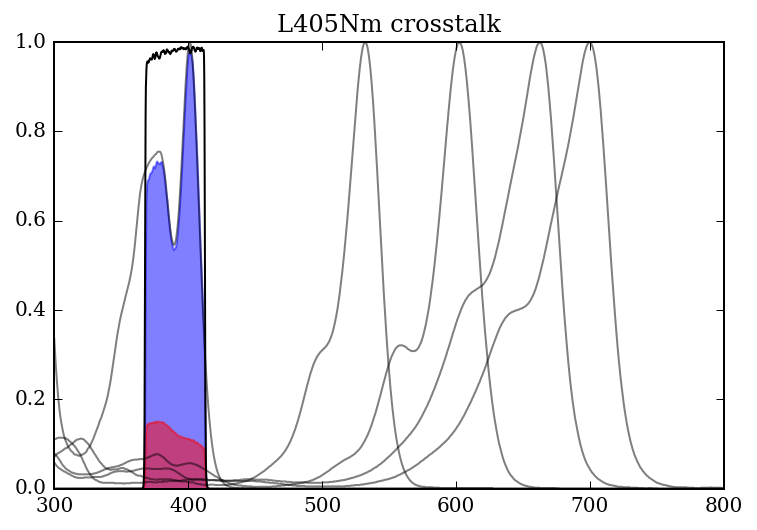

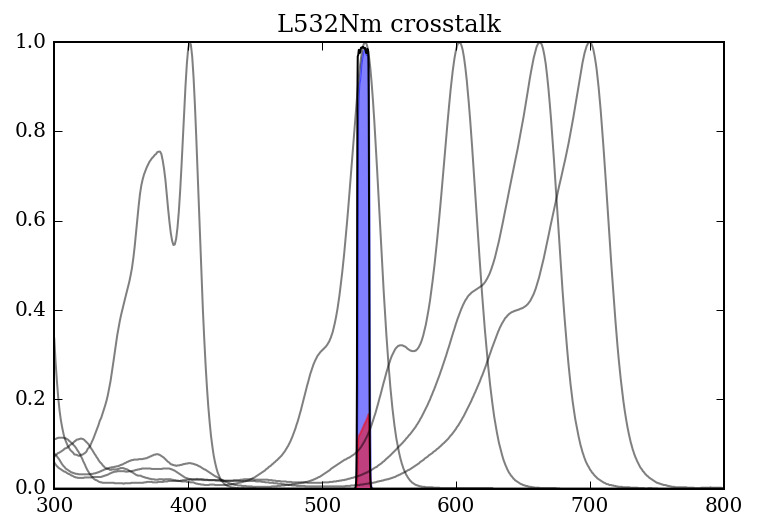

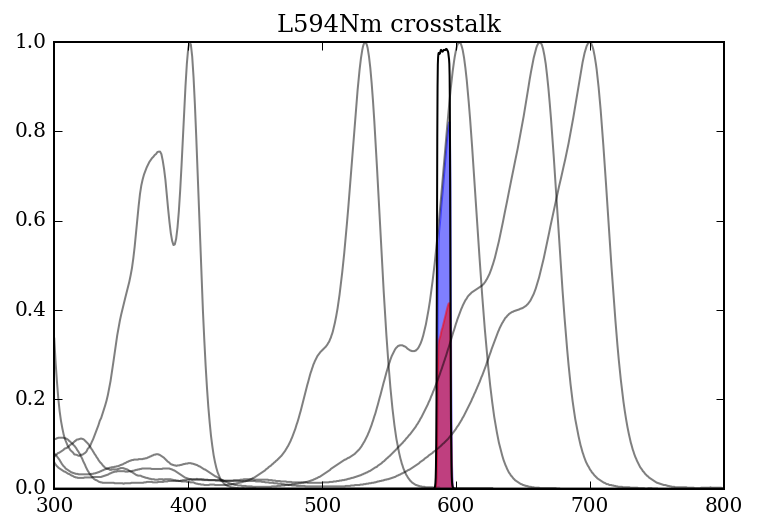

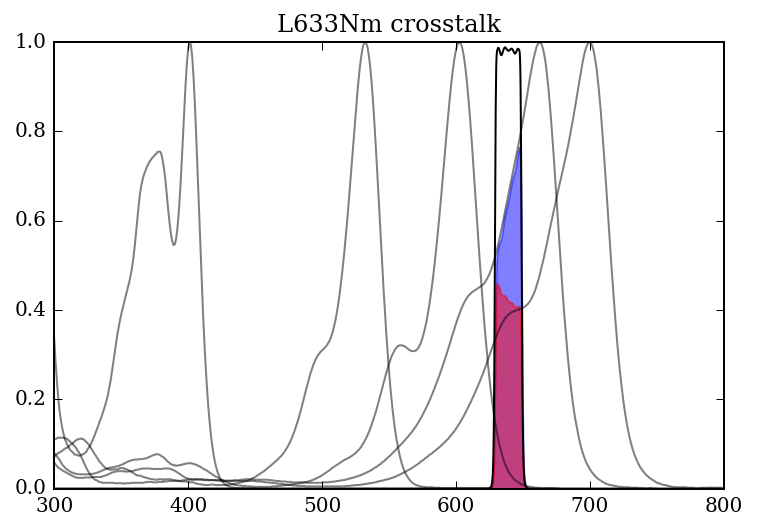

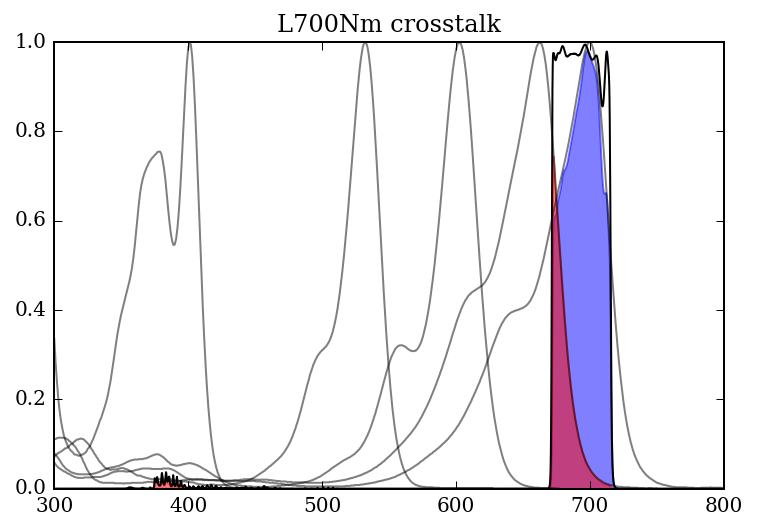

In [9]:
%matplotlib inline
show_dye_excitation_enclosed_by_filters(bb, dye_list, fc_list, 'crosstalk')

## Alternative filtersets

Try with Kerr's identified filter alternatives. Have to redefine functionality from above so comparison is with lasers with old filters rather than lasers with alternative filters. 

L405Nm
broadband/laser ratio = 41.967
L532Nm
broadband/laser ratio = 2.687
L594Nm
broadband/laser ratio = 2.322
L633Nm
broadband/laser ratio = 2.417
L700Nm
broadband/laser ratio = 1.775


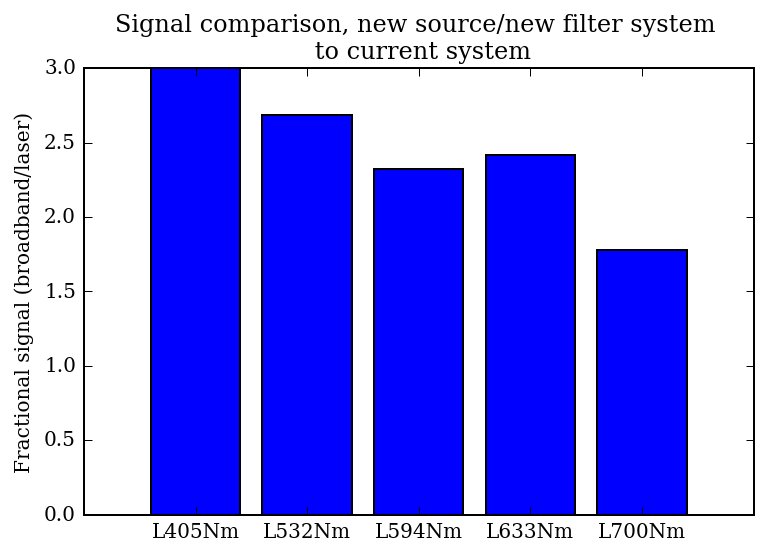

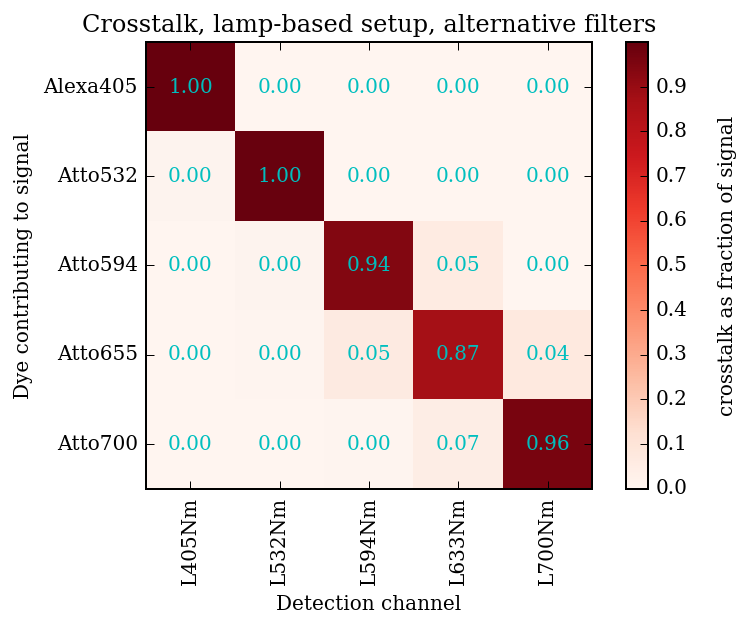

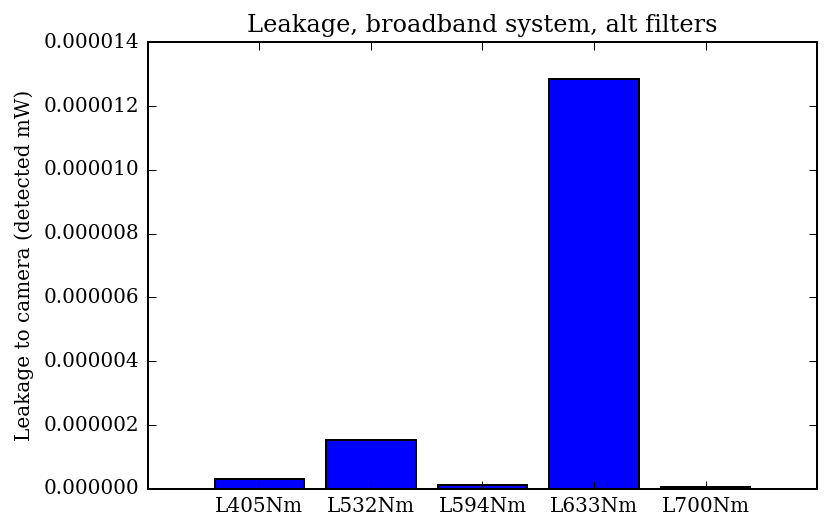

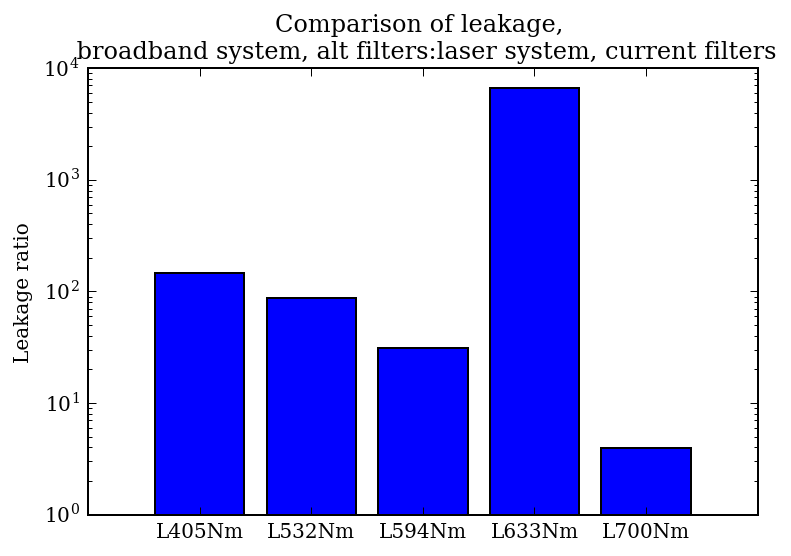

In [15]:
%matplotlib inline

altFc633 = FilterCube(channel = 'L633Nm', 
                   excitationFilter = ( 'FF01-642_10', os.path.join(filtersPath, 'FF01-642_10_spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R635', os.path.join(filtersPath, 'Di02-R635_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-679_41', os.path.join(filtersPath, 'FF01-679_41_Spectrum.txt') ) )
                   
altFc700new = FilterCube(channel = 'L700Nm', 
                   excitationFilter = ( 'FF01-700_13', os.path.join(filtersPath, 'FF01-700_13_Spectrum.txt') ), 
                   dichroicFilter = ( '725lpxr', os.path.join(filtersPath, 'Chroma 725lpxr.txt') ), 
                   emissionFilter = ( 'FF01-747_33', os.path.join(filtersPath, 'FF01-747_33_Spectrum.txt') ) )

alt_fc_list = [fc405, fc532, fc594, altFc633, altFc700new]

ratios = []
ch_labels = []
for l, b, fc, afc, dy in zip(laser_list, source_list, fc_list, alt_fc_list, dye_list):
    d, ch, sig_new = signalFromDyeXInChannelY(b, afc, dy, objective, camera)
    d, ch, sig_old = signalFromDyeXInChannelY(l, fc, dy, objective, camera)
    print(ch)
    print('broadband/laser ratio = {:0.3f}'.format((sig_new/sig_old)))

    ratios.append(sig_new/sig_old)
    ch_labels.append(ch)

fig3 = plt.figure();
plt.bar([1, 2, 3, 4, 5], 
        ratios, 
        tick_label=ch_labels, 
        align='center')
plt.ylabel('Fractional signal (broadband/laser)')
plt.ylim([0, 3])
plt.title("Signal comparison, new source/new filter system \n to current system")
plt.show()

displayCrosstalkPlot(source_list, 
                     alt_fc_list, 
                     dye_list, 
                     objective, camera, log_colour=False, title='Crosstalk, lamp-based setup, alternative filters')
#plt.title('Crosstalk, lamp-based setup, alternative filters')


alt_bb_leakage = [calc_leakage(sr, fc, objective, camera) for sr, fc in zip(source_list, alt_fc_list)]
fig5 = plt.figure();
plt.bar([1, 2, 3, 4, 5], 
        alt_bb_leakage, 
        tick_label=ch_labels, 
        align='center')
plt.ylabel('Leakage to camera (detected mW)')
plt.title('Leakage, broadband system, alt filters')
plt.show()

leak_ratio = [(bl/ll) for ll, bl in zip(laser_leakage, alt_bb_leakage)]
fig6 = plt.figure();
plt.bar([1, 2, 3, 4, 5], 
        leak_ratio, 
        tick_label=ch_labels, 
        align='center')
plt.yscale('log')
plt.ylabel('Leakage ratio')
plt.title("Comparison of leakage, \n broadband system, alt filters:laser system, current filters")
plt.show()


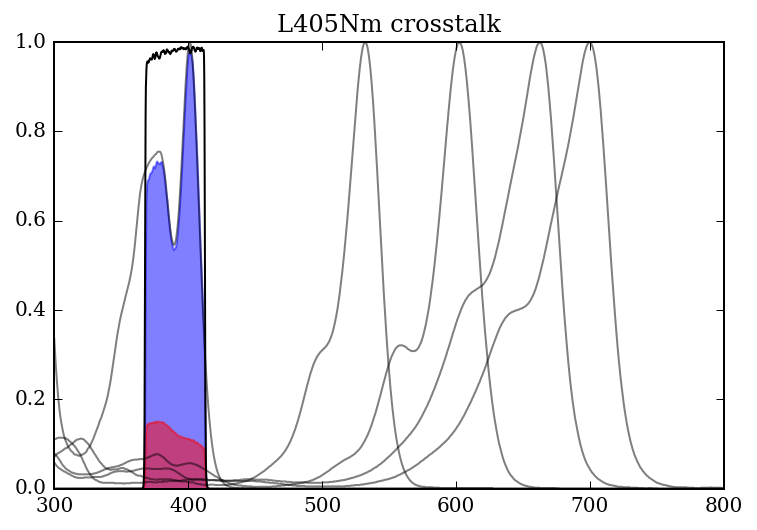

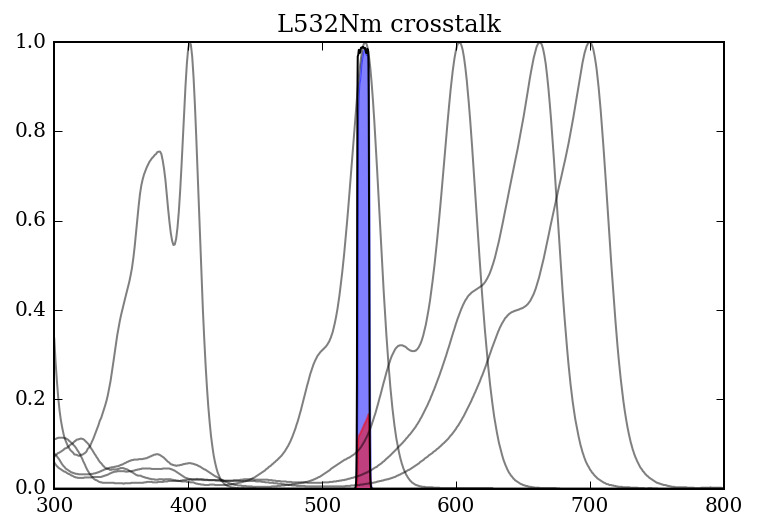

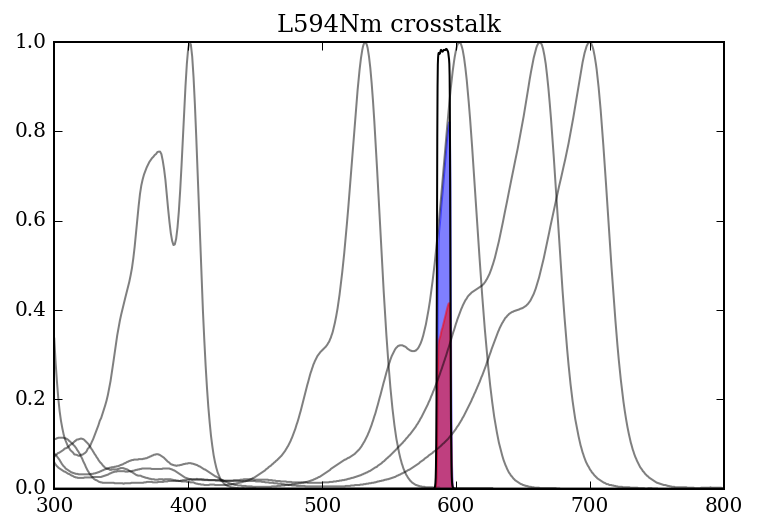

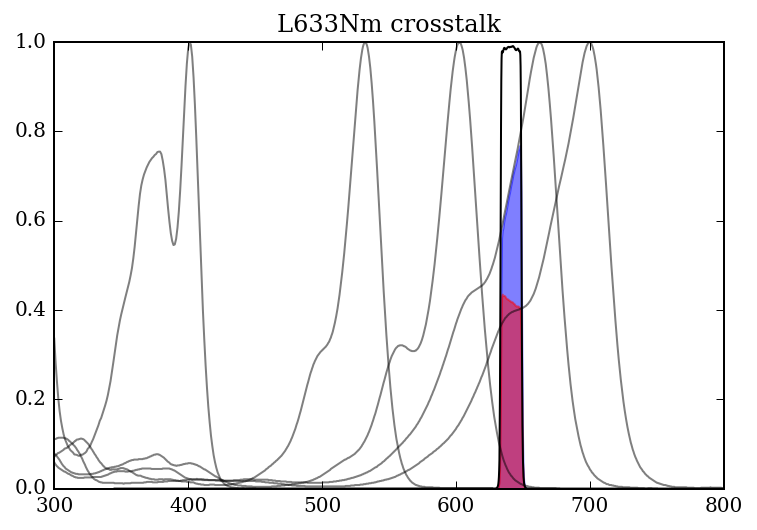

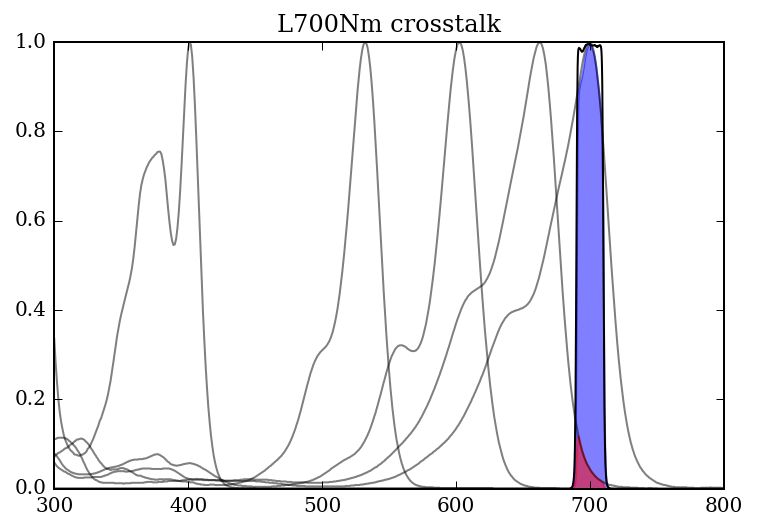

In [11]:
show_dye_excitation_enclosed_by_filters(bb, dye_list, alt_fc_list, 'crosstalk')